## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
import itertools
from tqdm import tqdm

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
df = pd.read_csv('E:/PTDLKD/Đồ án/dataset/INTC.csv')
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,45.959999,47.470001,45.770000,47.080002,41.343937,18774600
1,2019-01-03,46.150002,46.279999,44.389999,44.490002,39.069477,32267300
2,2019-01-04,45.840000,47.570000,45.540001,47.220001,41.466869,35447300
3,2019-01-07,47.099998,48.000000,46.750000,47.439999,41.660065,22736800
4,2019-01-08,47.799999,48.029999,46.779999,47.740002,41.923512,22749200
5,2019-01-09,47.959999,48.570000,47.779999,48.009998,42.160622,22554500
6,2019-01-10,47.750000,48.650002,47.410000,48.560001,42.643612,27202600
7,2019-01-11,48.099998,49.290001,48.049999,48.930000,42.968521,21751300
8,2019-01-14,48.459999,48.830002,48.299999,48.349998,42.459190,19193900
9,2019-01-15,48.709999,49.130001,48.439999,48.599998,42.678734,22480800


## Data preprocessing

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [4]:
# Show Dataframe
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,45.959999,47.470001,45.770000,47.080002,41.343937,18774600
2019-01-03,46.150002,46.279999,44.389999,44.490002,39.069477,32267300
2019-01-04,45.840000,47.570000,45.540001,47.220001,41.466869,35447300
2019-01-07,47.099998,48.000000,46.750000,47.439999,41.660065,22736800
2019-01-08,47.799999,48.029999,46.779999,47.740002,41.923512,22749200
...,...,...,...,...,...,...
2023-06-06,29.770000,31.450001,29.700001,30.959999,30.959999,42295300
2023-06-07,31.030001,31.370001,30.930000,31.280001,31.280001,39098000
2023-06-08,31.430000,31.850000,31.059999,31.820000,31.820000,35199000


## Split the data into train, validation and test set with a ratio of 6 : 2 : 2

In [5]:
# Define the size of train, validation, test set
train_size = int(len(df) * 0.6)
val_size = int(len(df) * 0.2)
test_size = len(df) - train_size - val_size

# Split the data into train, test and validation set
train_data = df.iloc[0 : train_size, :]
val_data = df.iloc[train_size : train_size + val_size, :]
test_data = df.iloc[train_size + val_size : len(df), :]

## Extracting features

Create function augment_features to calculate the fractional change in:
1. Opening and closing prices (fracocp)
2. High prices (frachp)
3. Low prices (fraclp)

In [6]:
def augment_features(dataframe):
    fracocp = (dataframe['Close']-dataframe['Open'])/dataframe['Open']
    frachp = (dataframe['High']-dataframe['Open'])/dataframe['Open']
    fraclp = (dataframe['Open']-dataframe['Low'])/dataframe['Open']
    new_dataframe = pd.DataFrame({'delOpenClose': fracocp,
                                 'delHighOpen': frachp,
                                 'delLowOpen': fraclp})
    new_dataframe.set_index(dataframe.index)
    
    return new_dataframe

Function extract_features will combine the 3 calculated fractional change into 1 array

In [7]:
def extract_features(dataframe):
    return np.column_stack((dataframe['delOpenClose'], dataframe['delHighOpen'], dataframe['delLowOpen']))

## Build Model

In [8]:
# Set the quantity of hidden states is 10
model = GaussianHMM(n_components=10)

In [9]:
# Extract features of train set
feature_train_data = augment_features(train_data)
features_train = extract_features(feature_train_data)

# Training model
model.fit(features_train)

c:\Users\Admin\.conda\envs\user_env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
Model is not converging.  Current: 6309.9077777829125 is not greater than 6311.330338270482. Delta is -1.4225604875691715


GaussianHMM(n_components=10)

In [10]:
# Using 50 days in the past to predict the closing price of the current day
num_latent_days = 50

# Determine the number of days will be predicted is 30 days
# num_days_to_predict = 30

## Evaluate in validation set

In [11]:
# Extract features of validation set
val_augmented = augment_features(val_data) 
val_fracocp = val_augmented['delOpenClose']
val_frachp = val_augmented['delHighOpen']
val_fraclp = val_augmented['delLowOpen']

# Divide validation set's feature values into parts
val_sample_space_fracocp = np.linspace(val_fracocp.min(), val_fracocp.max(), 50) 
val_sample_space_fraclp = np.linspace(val_fraclp.min(), val_frachp.max(), 10)
val_sample_space_frachp = np.linspace(val_frachp.min(), val_frachp.max(), 10)

# Generate the possible permutations of values for the features of validation set
possible_outcomes = np.array(list(itertools.product(val_sample_space_fracocp, val_sample_space_frachp, val_sample_space_fraclp)))

In [12]:
# best_num_step stores the number of steps in the interval that the features take
best_num_step = None

# best_mae stores the best Mean Absolute Error value
best_mae = float('inf')

In [13]:
# Experiment and find the best number of steps between 10 and 50
for num_step in np.arange(10, 50, 10):
    sample_space_fracocp = np.linspace(val_fracocp.min(), val_fracocp.max(), num_step)
    sample_space_fraclp = np.linspace(val_fraclp.min(), val_frachp.max(), int(num_step/5))
    sample_space_frachp = np.linspace(val_frachp.min(), val_frachp.max(), int(num_step/5))
    possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))
    
    predicted_close_prices = []
    
    for i in tqdm(range(val_size)):
        # Calculate start and end indices
        previous_data_start_index = max(0, i - num_latent_days)
        previous_data_end_index = max(0, i)
        # Acquire validation data features for these days
        previous_data = extract_features(augment_features(val_data.iloc[previous_data_start_index:previous_data_end_index]))

        outcome_scores = []
        for outcome in possible_outcomes:
            # Append each outcome one by one with replacement to see which sequence generates the highest score
            total_data = np.row_stack((previous_data, outcome))
            outcome_scores.append(model.score(total_data))

        # Take the most probable outcome as the one with the highest score
        most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
        predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))
    
    # Calculate MAE value
    mae = (abs(val_data['Close'] - predicted_close_prices)).mean()

    # Compare and find the best number of steps and the best MAE value
    if mae < best_mae:
        best_num_step = num_step
        best_mae = mae

  2%|▏         | 5/223 [00:00<00:05, 39.47it/s]

100%|██████████| 223/223 [08:56<00:00,  2.41s/it]


In [14]:
# Show the best number of steps
print("The best number of steps is : ", best_num_step)

The best number of steps is :  40


## Predict validate dataset with the best number of steps

In [15]:
# Divide validate dataset's feature values into parts
val_sample_space_fracocp = np.linspace(val_fracocp.min(), val_fracocp.max(), best_num_step) 
val_sample_space_fraclp = np.linspace(val_fraclp.min(), val_frachp.max(), int(best_num_step/5))
val_sample_space_frachp = np.linspace(val_frachp.min(), val_frachp.max(), int(best_num_step/5))

# Generate the possible permutations of values for the features of test set
possible_outcomes = np.array(list(itertools.product(val_sample_space_fracocp, val_sample_space_frachp, val_sample_space_fraclp)))

In [16]:
y_pred_val = []

for i in tqdm(range(val_size)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Calculate start and end indices
    previous_data = extract_features(augment_features(val_data.iloc[previous_data_start_index:previous_data_end_index]))
    
    outcome_scores = []
    for outcome in possible_outcomes:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.row_stack((previous_data, outcome))
        outcome_scores.append(model.score(total_data)) 
        
    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
    y_pred_val.append(val_data.iloc[i]['Open'] * (1 + most_probable_outcome[0])) 

  0%|          | 0/223 [00:00<?, ?it/s]

100%|██████████| 223/223 [06:23<00:00,  1.72s/it]


## Predict test dataset with the best number of steps

In [17]:
# Extract features of test set
test_augmented = augment_features(test_data) 
fracocp = test_augmented['delOpenClose']
frachp = test_augmented['delHighOpen']
fraclp = test_augmented['delLowOpen']

# Divide test set's feature values into parts
sample_space_fracocp = np.linspace(fracocp.min(), fracocp.max(), best_num_step) 
sample_space_fraclp = np.linspace(fraclp.min(), frachp.max(), int(best_num_step/5))
sample_space_frachp = np.linspace(frachp.min(), frachp.max(), int(best_num_step/5))

# Generate the possible permutations of values for the features of test set
possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))

In [18]:
y_pred = []

for i in tqdm(range(test_size)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Calculate start and end indices
    previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))
    
    outcome_scores = []
    for outcome in possible_outcomes:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.row_stack((previous_data, outcome))
        outcome_scores.append(model.score(total_data)) 
        
    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
    y_pred.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0])) 

100%|██████████| 225/225 [03:51<00:00,  1.03s/it]


## Calculate the error of the model

In [19]:
# Select the test values in reality
y_act = test_data['Close']
y_act = y_act.values

In [20]:
# The error in test set
test_mape = mean_absolute_percentage_error(y_act, y_pred)
test_mse = mean_squared_error(y_act, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_act, y_pred)

print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)

MAPE on Test dataset:  0.016692949657117224
RMSE on Test dataset:  0.6280426788668559
MSLE on Test dataset:  0.0004212129517874739


In [21]:
# Select the validation values in reality
y_act_val = val_data['Close']
y_act_val = y_act_val.values

In [22]:
# The error in test set
val_mape = mean_absolute_percentage_error(y_act_val, y_pred_val)
val_mse = mean_squared_error(y_act_val, y_pred_val)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_act_val, y_pred_val)

print(f"MAPE on Validate dataset: ", val_mape)
print(f"RMSE on Validate dataset: ", val_rmse)
print(f"MSLE on Validate dataset: ", val_msle)

MAPE on Validate dataset:  0.012729828978238685
RMSE on Validate dataset:  0.7744123185667516
MSLE on Validate dataset:  0.0002539231146093761


## Model visualization

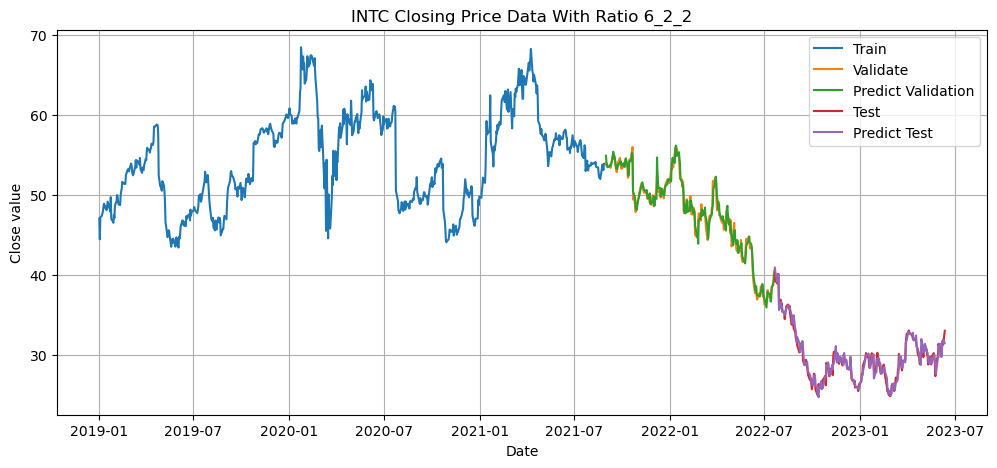

In [23]:
plt.figure(figsize=(12, 5))

# Train set
plt.plot(df[:train_size].index, train_data['Close'].values)

# Validation set
plt.plot(df[train_size : train_size + val_size].index, val_data['Close'].values)

# Predict in validate dataset
plt.plot(df[train_size : train_size + val_size].index, y_pred_val)

# Test set
plt.plot(df[train_size + val_size: ].index, test_data['Close'].values)

# Predict in test set
plt.plot(df[train_size + val_size:].index, y_pred)

# Predict 30 next days
# plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'Predict Validation', 'Test', 'Predict Test'])
plt.grid()
plt.title("INTC Closing Price Data With Ratio 6_2_2")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('HMM_622_INTC.png')
plt.show()